## Import Modules

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = 'D:/GitHub/Image Caption Generator - Flickr Dataset/data/archive/'
WORKING_DIR = 'D:/GitHub/Image Caption Generator - Flickr Dataset/data/'

## Extract Image Features

In [3]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [4]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [23]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [7]:
captions_doc

'1305564994_00513f9a5b,man in street racer armor be examine the tire of another racer motorbike.\n1305564994_00513f9a5b,two racer drive white bike down road.\n1305564994_00513f9a5b,two motorist be ride along on their vehicle that be oddly design and color.\n1305564994_00513f9a5b,two person be in small race car drive by green hill.\n1305564994_00513f9a5b,two person in race uniform in street car.\n1351764581_4d4fb1b40f,firefighter extinguish fire under the hood of car.\n1351764581_4d4fb1b40f,fireman spray water into the hood of small white car on jack.\n1351764581_4d4fb1b40f,fireman spray inside the open hood of small white car on jack.\n1351764581_4d4fb1b40f,fireman use firehose on car engine that be up on carjack.\n1351764581_4d4fb1b40f,firefighter use water to extinguish car that be on fire.\n1358089136_976e3d2e30,boy sand surf down hill.\n1358089136_976e3d2e30,man be attempt to surf down hill make of sand on sunny day.\n1358089136_976e3d2e30,man be slide down huge sand dune on sunny 

In [24]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40455 [00:00<?, ?it/s]

In [25]:
len(mapping)

8091

## Preprocess Text Data

In [26]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [27]:
mapping['1000268201_693b08cb0e']

['child in pink dress be climb up set of stair in an entry way.',
 'girl go into wooden building.',
 'little girl climb into wooden playhouse.',
 'little girl climb the stair to her playhouse.',
 'little girl in pink dress go into wooden cabin.']

In [28]:
clean(mapping)

In [29]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress be climb up set of stair in an entry way. endseq',
 'startseq girl go into wooden building. endseq',
 'startseq little girl climb into wooden playhouse. endseq',
 'startseq little girl climb the stair to her playhouse. endseq',
 'startseq little girl in pink dress go into wooden cabin. endseq']

In [30]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [31]:
len(all_captions)

40455

In [32]:
all_captions[:10]

['startseq man in street racer armor be examine the tire of another racer motorbike. endseq',
 'startseq two racer drive white bike down road. endseq',
 'startseq two motorist be ride along on their vehicle that be oddly design and color. endseq',
 'startseq two person be in small race car drive by green hill. endseq',
 'startseq two person in race uniform in street car. endseq',
 'startseq firefighter extinguish fire under the hood of car. endseq',
 'startseq fireman spray water into the hood of small white car on jack. endseq',
 'startseq fireman spray inside the open hood of small white car on jack. endseq',
 'startseq fireman use firehose on car engine that be up on carjack. endseq',
 'startseq firefighter use water to extinguish car that be on fire. endseq']

In [33]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [34]:
vocab_size

6689

In [35]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

## Train Test Split

In [36]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [38]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

In [39]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [49]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 243s 1s/step - loss: 2.2304


In [50]:
model.save(WORKING_DIR+'/best_model.h5')

## Generate Captions for the Image

In [51]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [52]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
      
    return in_text

In [53]:
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)


  0%|          | 0/810 [00:00<?, ?it/s]

## Visualize the Results

In [62]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print(y_pred)
    plt.imshow(image)

In [63]:
generate_caption("1001773457_577c3a7d70.jpg")

startseq young girl be splash in pool endseq


NameError: name 'image' is not defined

startseq child play with streamer endseq


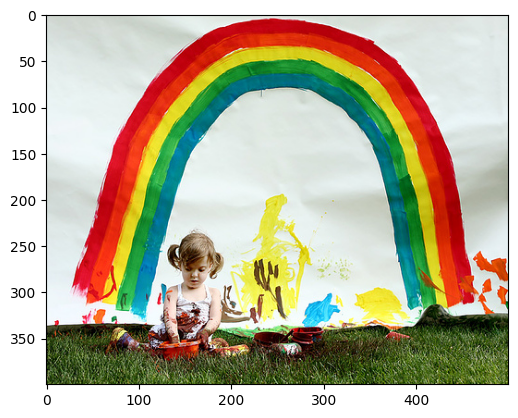

In [56]:
generate_caption("1002674143_1b742ab4b8.jpg")

startseq child bundle up on the side of tree endseq


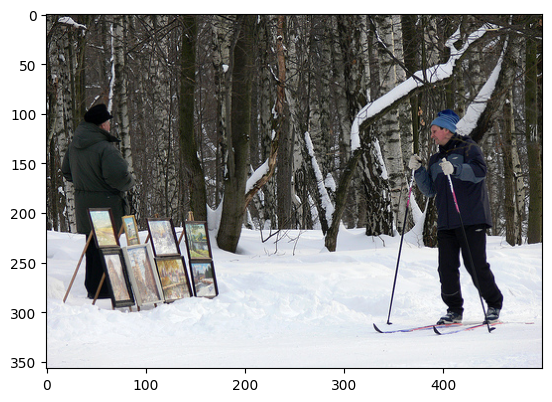

In [57]:
generate_caption("101669240_b2d3e7f17b.jpg")

startseq girl in bathe suit be splash through water endseq


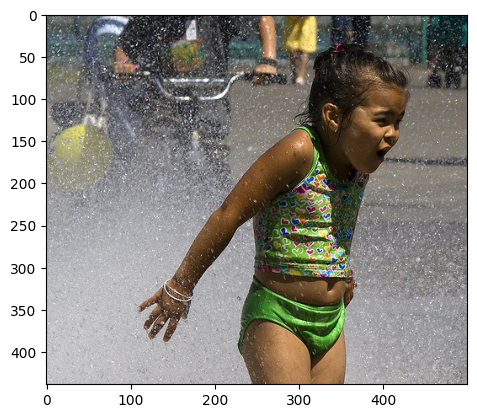

In [58]:
generate_caption("3765374230_cb1bbee0cb.jpg")

startseq young boy in blue bathe suit be play in the air endseq


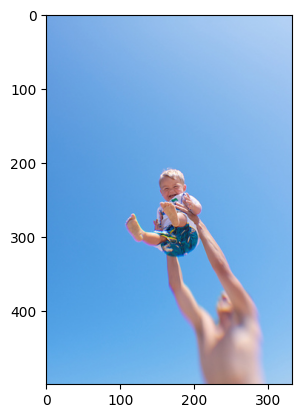

In [61]:
generate_caption('3726730085_2468ee9220.jpg')